In [2]:
import csv
import gsw
import numpy as np
import pycnv
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from cmocean import cm as cmo

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [177]:
import warnings
warnings.filterwarnings("ignore")


  # Silence warnings

# If want to fix warnings:
# * start_time = 02 May 2025 13:45:00    #(for example)
# * interval = seconds: 0.25             #(for example)


## DAY 1

In [178]:
fname = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv'
cnv = pycnv.pycnv(fname)
print('Test if we are in the Baltic Sea (usage of different equation of state): ' + str(cnv.baltic))
print('Position of cast is: Longitude:', cnv.lon,'Latitude:',cnv.lat)
print('Time of cast was:', cnv.date)
print('Number of sensor entries (len(cnv.data.keys())):',len(cnv.data.keys()))
print('Names of sensor entries (cnv.data.keys()):',cnv.data.keys())

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Test if we are in the Baltic Sea (usage of different equation of state): False
Position of cast is: Longitude: 10.9285 Latitude: 57.5575
Time of cast was: 2025-05-06 13:52:11+00:00
Number of sensor entries (len(cnv.data.keys())): 18
Names of sensor entries (cnv.data.keys()): dict_keys(['scan', 'prDM', 'p', 't090C', 'T0', 'c0S/m', 'C0', 'flECO-AFL', 'sbeox0V', 'oxy0', 'turbWETntu0', 'turb', 'depSM', 'depSM@7', 'sal00', 'sbeox0Mm/L', 'sbeox0PS', 'flag'])


**Potential density**

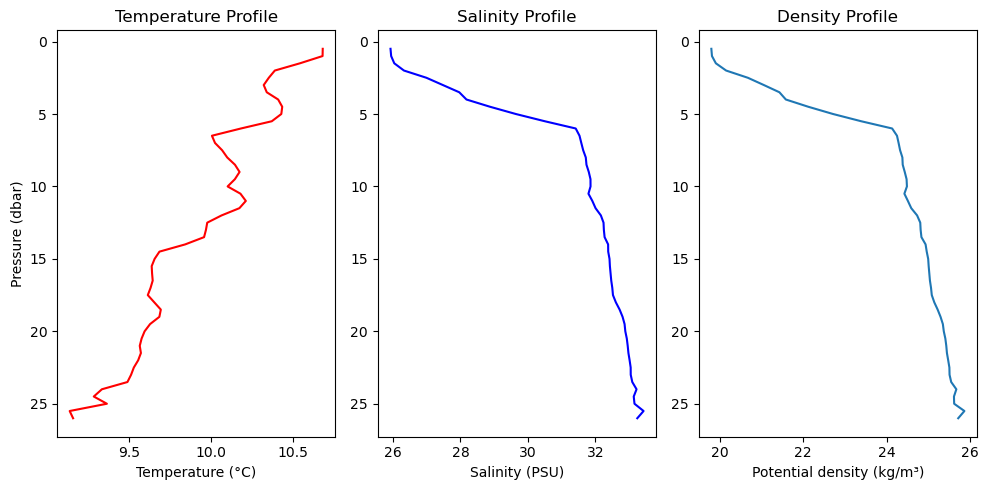

In [179]:
sal = np.array(cnv.data['sal00'])      # Practical Salinity (PSU)
temp = np.array(cnv.data['t090C'])     # In-situ temperature (°C)
pres = np.array(cnv.data['prDM'])      # Pressure (dbar)
lat = cnv.lat
lon = cnv.lon

# Convert to Absolute Salinity (g/kg)
SA = gsw.SA_from_SP(sal, pres, lon, lat)

# Convert to Conservative Temperature (°C)
CT = gsw.CT_from_t(SA, temp, pres)

sigma0 = gsw.density.sigma0(SA,CT)
pressure = cnv.data['p']      
temperature = cnv.data['t090C'] 
salinity = cnv.data['sal00']   
depth = cnv.data['depSM']

plt.figure(figsize=(10, 5))

# Plot Temperature
plt.subplot(1, 3, 1)
plt.plot(temperature, depth, 'r')
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.title('Temperature Profile')

# Plot Salinity
plt.subplot(1, 3, 2)
plt.plot(salinity, depth, 'b')
plt.gca().invert_yaxis()
plt.xlabel('Salinity (PSU)')
plt.title('Salinity Profile')

plt.subplot(1, 3, 3)
plt.plot(sigma0, depth)
plt.gca().invert_yaxis()
plt.xlabel('Potential density (kg/m³)')
plt.title('Density Profile')


plt.tight_layout()
plt.show()

# Along track for day 1

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


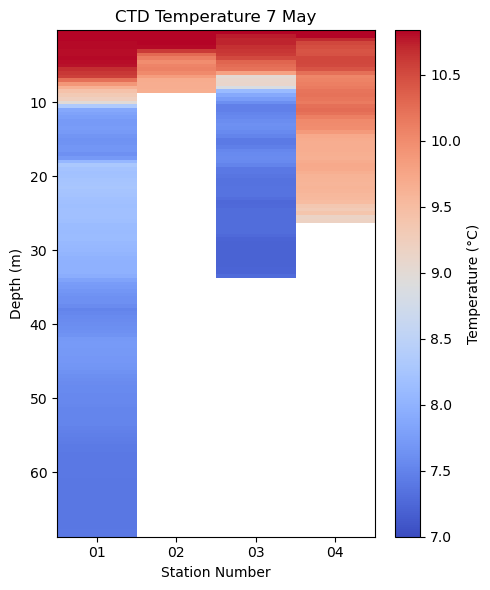

In [180]:
# Settings
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv',
]

all_depths = []
all_temps = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])  # pressure
    t = np.array(cnv.data['t090C'])  # in-situ temperature
    sp = np.array(cnv.data['sal00'])  # practical salinity
    lat = cnv.lat
    lon = cnv.lon

    # Compute Absolute Salinity and Conservative Temperature
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    depth = np.array(cnv.data['depSM'])  # keep original depth for plotting

    all_depths.append(depth)
    all_temps.append(CT)


# Plot
plt.figure(figsize=(5, 6))

for i, (depth, temp) in enumerate(zip(all_depths, all_temps)):
    # Compute edges for depth
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])

    x_edges = [i - 0.5, i + 0.5]

    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)

    # Expand temp to match (M-1, N-1) = (len(depth), 1)
    T = temp.reshape(-1, 1)

    plt.pcolormesh(X_grid, Y_grid, T, shading='auto', cmap='coolwarm', vmin=7)

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature (°C)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title('CTD Temperature 7 May')
plt.tight_layout()
plt.show()




INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


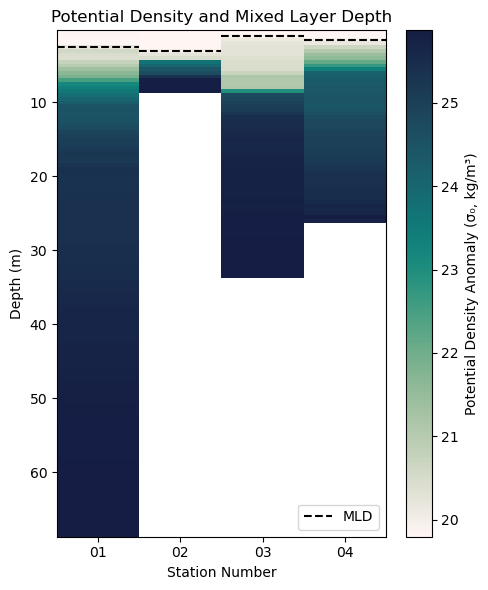

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw

# Settings
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv',
]

all_depths = []
all_sigma0 = []
mld_list = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute SA and CT
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    # Compute sigma0
    sigma0 = gsw.sigma0(SA, CT)

    # Mixed layer depth (simple threshold method)
    sigma0_surface = sigma0[0]
    mld = np.nan
    for d, s in zip(depth, sigma0):
        if s - sigma0_surface > 0.03:
            mld = d
            break
    mld_list.append(mld)

    all_depths.append(depth)
    all_sigma0.append(sigma0)

# Plot
plt.figure(figsize=(5, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    # Compute edges
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    # Plot sigma0
    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap=cmo.tempo,
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    # Plot MLD as horizontal line
    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linewidth=1.5, linestyle='--', label='MLD' if i == 0 else "")

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title('Potential Density and Mixed Layer Depth')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


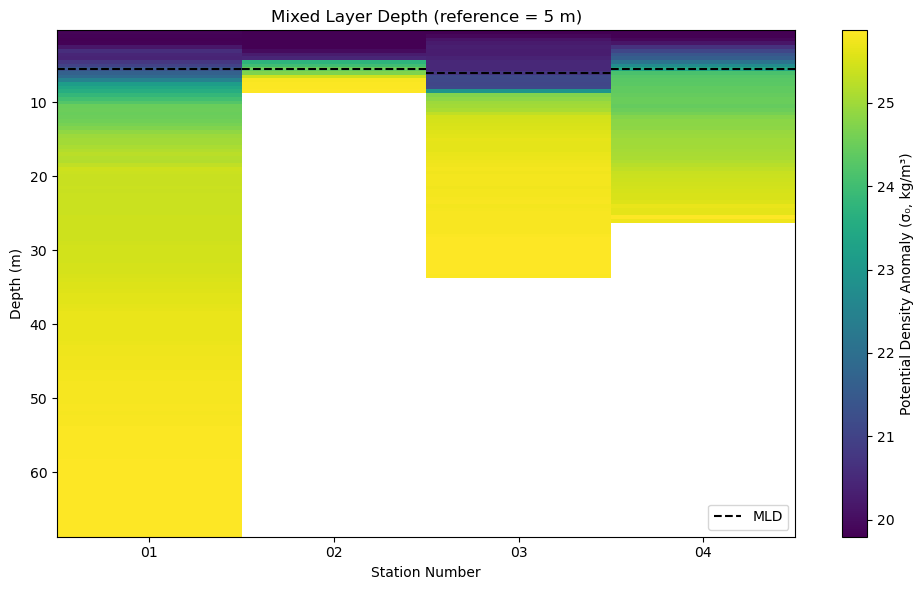

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw

# Settings
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv',
]
# --- Initialize ---
all_depths = []
all_sigma0 = []
mld_list = []

# --- MLD Parameters ---
ref_depth = 5  # reference depth in meters
delta_rho_threshold = 0.03  # kg/m³

# --- Loop over files ---
for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute conservative parameters
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)

    # Remove NaNs if any
    valid = ~np.isnan(sigma0) & ~np.isnan(depth)
    depth = depth[valid]
    sigma0 = sigma0[valid]

    # -- MLD calculation using reference depth --
    if len(depth) == 0:
        mld_list.append(np.nan)
        continue

    # Find index closest to reference depth
    ref_idx = np.argmin(np.abs(depth - ref_depth))
    rho_ref = sigma0[ref_idx]

    # Find first depth where Δσ₀ > threshold
    delta_sigma = sigma0 - rho_ref
    above_thresh = np.where(delta_sigma > delta_rho_threshold)[0]

    if len(above_thresh) > 0:
        # Pick the first depth *below the reference* that exceeds threshold
        deeper_than_ref = above_thresh[depth[above_thresh] > depth[ref_idx]]
        mld = depth[deeper_than_ref[0]] if len(deeper_than_ref) > 0 else np.nan
    else:
        mld = np.nan

    mld_list.append(mld)
    all_depths.append(depth)
    all_sigma0.append(sigma0)

# --- Plot ---
plt.figure(figsize=(10, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    # Depth edges for pcolormesh
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap='viridis',
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linestyle='--', linewidth=1.5,
                   label='MLD' if i == 0 else None)

# Final touches
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title(f'Mixed Layer Depth (reference = {ref_depth} m)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [148]:
import os

data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv',
]

def extract_depths_from_cnv(filename):
    depths = []
    with open(filename) as f:
        data_started = False
        for line in f:
            if line.strip().startswith("*END*"):
                data_started = True
                continue
            if data_started:
                parts = line.strip().split()
                if len(parts) > 0:
                    try:
                        depth = float(parts[1])  # assumes depth is in 2nd column
                        depths.append(depth)
                    except ValueError:
                        continue
    return depths

for fname in fnames:
    full_path = os.path.join(data_folder, fname)
    depths = extract_depths_from_cnv(full_path)
    print(f"Depths from {fname}:")
    print(depths)



Depths from CTD_01_avg.cnv:
[0.505, 1.009, 1.514, 2.019, 2.523, 3.028, 3.533, 4.037, 4.542, 5.047, 5.551, 6.056, 6.561, 7.065, 7.57, 8.075, 8.579, 9.084, 9.589, 10.093, 10.598, 11.103, 11.607, 12.112, 12.617, 13.122, 13.626, 14.131, 14.636, 15.14, 15.645, 16.15, 16.654, 17.159, 17.664, 18.169, 18.673, 19.178, 19.683, 20.187, 20.692, 21.197, 21.701, 22.206, 22.711, 23.216, 23.72, 24.225, 24.73, 25.234, 25.739, 26.244, 26.749, 27.253, 27.758, 28.263, 28.768, 29.272, 29.777, 30.282, 30.786, 31.291, 31.796, 32.301, 32.805, 33.31, 33.815, 34.32, 34.824, 35.329, 35.834, 36.339, 36.843, 37.348, 37.853, 38.358, 38.862, 39.367, 39.872, 40.377, 40.881, 41.386, 41.891, 42.396, 42.9, 43.405, 43.91, 44.415, 44.919, 45.424, 45.929, 46.434, 46.939, 47.443, 47.948, 48.453, 48.958, 49.462, 49.967, 50.472, 50.977, 51.482, 51.986, 52.491, 52.996, 53.501, 54.006, 54.51, 55.015, 55.52, 56.025, 56.529, 57.034, 57.539, 58.044, 58.549, 59.053, 59.558, 60.063, 60.568, 61.073, 61.577, 62.082, 62.587, 63.092, 63

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


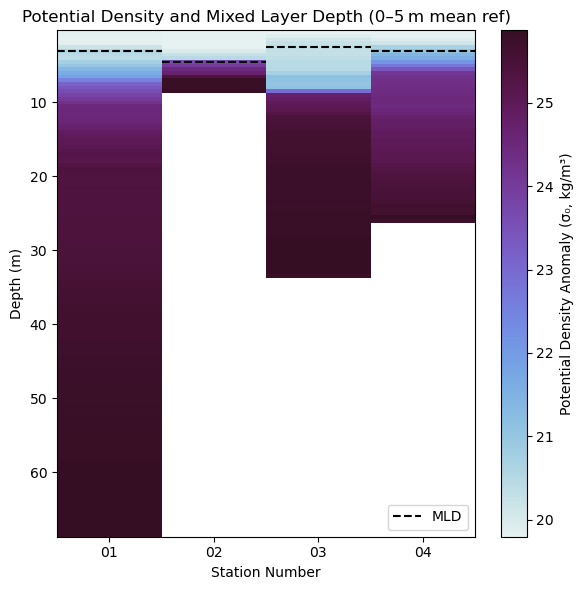

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw
import cmocean

# Folder and filenames
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv'
]

# Initialize storage
all_depths = []
all_sigma0 = []
mld_list = []

# Parameters
delta_sigma = 0.03  # density threshold
ref_depth_limit = 5  # upper depth limit (m) for mean reference

# Loop through files
for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute Absolute Salinity and Conservative Temperature
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    # Compute sigma0
    sigma0 = gsw.sigma0(SA, CT)

    # Use the average σ₀ in the top X meters (0–5 m) as reference
    shallow_mask = depth <= ref_depth_limit
    if np.any(shallow_mask):
        sigma0_ref = np.nanmean(sigma0[shallow_mask])
    else:
        sigma0_ref = sigma0[0]  # fallback if no shallow values

    # Find first depth where Δσ₀ > threshold
    mld = np.nan
    for d, s in zip(depth, sigma0):
        if s - sigma0_ref > delta_sigma:
            mld = d
            break

    mld_list.append(mld)
    all_depths.append(depth)
    all_sigma0.append(sigma0)

# Plotting
plt.figure(figsize=(6, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    # Plot sigma0
    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap=cmocean.cm.dense,
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    # Plot MLD as line
    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linestyle='--', linewidth=1.5,
                   label='MLD' if i == 0 else "")

# Final touches
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title(f'Potential Density and Mixed Layer Depth (0–{ref_depth_limit} m mean ref)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


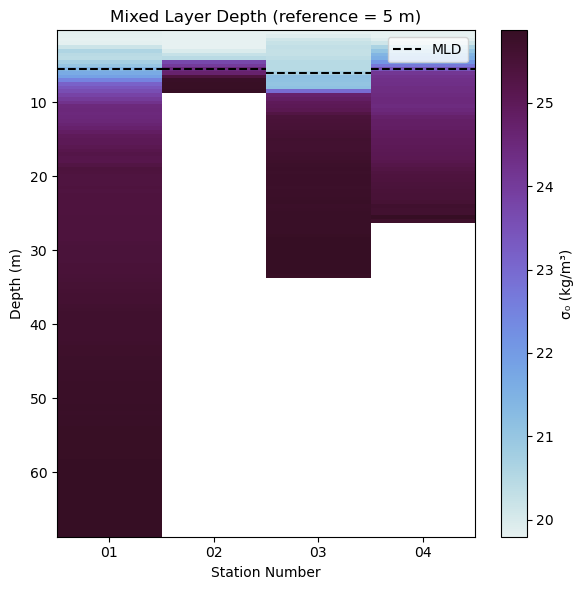

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw
import cmocean

# Settings
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv',
]

# Load data and convert to 2D matrices
all_depths = []
all_sigma0 = []

max_len = 0
for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))
    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)

    all_depths.append(depth)
    all_sigma0.append(sigma0)
    max_len = max(max_len, len(depth))

# Create uniform 2D arrays
n_profiles = len(fnames)
depth_matrix = np.full((max_len, n_profiles), np.nan)
density_matrix = np.full((max_len, n_profiles), np.nan)

for i in range(n_profiles):
    d = all_depths[i]
    s = all_sigma0[i]
    depth_matrix[:len(d), i] = d
    density_matrix[:len(s), i] = s

# === MLD Calculation ===
ref_depth = 5
delta_rho = 0.03
mld = np.full(n_profiles, np.nan)

for i in range(n_profiles):
    depth_col = depth_matrix[:, i]
    dens_col = density_matrix[:, i]

    # Skip if all NaN
    if np.all(np.isnan(depth_col)) or np.all(np.isnan(dens_col)):
        continue

    # Get ref index closest to 10m
    ref_idx = np.nanargmin(np.abs(depth_col - ref_depth))
    rho_ref = dens_col[ref_idx]

    # Find first depth exceeding threshold
    for d, rho in zip(depth_col, dens_col):
        if rho - rho_ref > delta_rho:
            mld[i] = d
            break

# === Plot ===
plt.figure(figsize=(6, 6))

for i in range(n_profiles):
    d = depth_matrix[:, i]
    s = density_matrix[:, i]

    valid = ~np.isnan(d) & ~np.isnan(s)
    if np.sum(valid) < 2:
        continue

    d = d[valid]
    s = s[valid]

    depth_edges = np.concatenate([
        [d[0] - (d[1] - d[0]) / 2],
        (d[1:] + d[:-1]) / 2,
        [d[-1] + (d[-1] - d[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X, Y = np.meshgrid(x_edges, depth_edges)

    S = s.reshape(-1, 1)
    pcm = plt.pcolormesh(X, Y, S, shading='auto', cmap=cmocean.cm.dense)

    if not np.isnan(mld[i]):
        plt.hlines(mld[i], i - 0.5, i + 0.5, color='black', linestyle='--', label='MLD' if i == 0 else "")

plt.gca().invert_yaxis()
plt.colorbar(pcm, label='σ₀ (kg/m³)')
plt.xticks(np.arange(n_profiles), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title(f'Mixed Layer Depth (reference = {ref_depth} m)')
plt.legend()
plt.tight_layout()
plt.show()


# Along track for day 2

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_05_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_06_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_07_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_08_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_09_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneD

Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


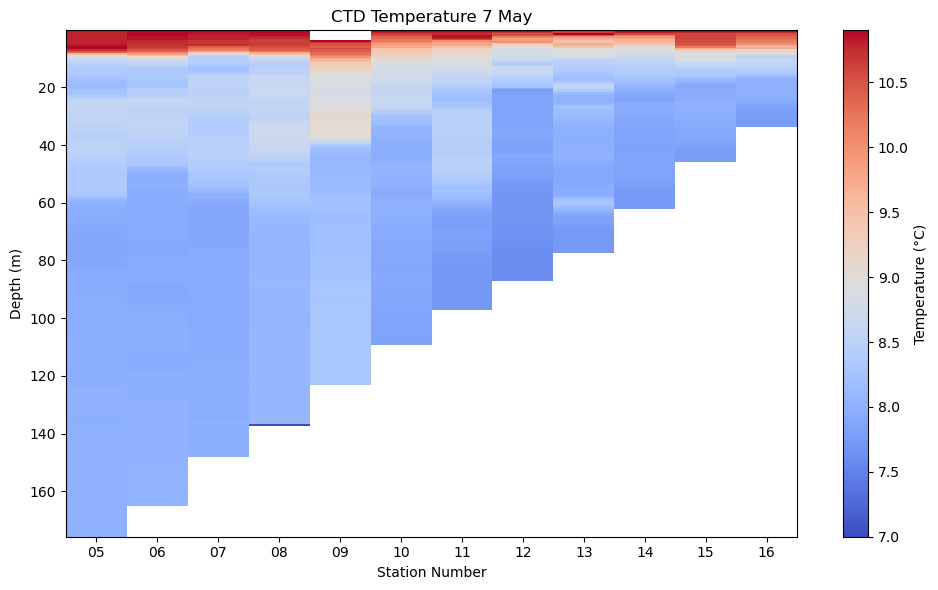

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
from cmocean import cm as cmo

# Folder and filenames
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_05_avg.cnv',
    'CTD_06_avg.cnv',
    'CTD_07_avg.cnv',
    'CTD_08_avg.cnv',
    'CTD_09_avg.cnv',
    'CTD_10_avg.cnv',
    'CTD_11_avg.cnv',
    'CTD_12_avg.cnv',
    'CTD_13_avg.cnv',
    'CTD_14_avg.cnv',
    'CTD_15_avg.cnv',
    'CTD_16_avg.cnv'
]

all_depths = []
all_temps = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))
    all_depths.append(np.array(cnv.data['depSM']))
    all_temps.append(np.array(cnv.data['t090C']))

# Plot
plt.figure(figsize=(10, 6))

for i, (depth, temp) in enumerate(zip(all_depths, all_temps)):
    # Compute edges for depth
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])

    x_edges = [i - 0.5, i + 0.5]

    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)

    # Expand temp to match (M-1, N-1) = (len(depth), 1)
    T = temp.reshape(-1, 1)

    plt.pcolormesh(X_grid, Y_grid, T, shading='auto', cmap='coolwarm', vmin=7)

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature (°C)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title('CTD Temperature 7 May')
plt.tight_layout()
plt.show()


INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_05_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_06_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_07_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_08_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_09_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneD

Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


INFO:pycnv:Converting conductivity units from S/m to mS/cm


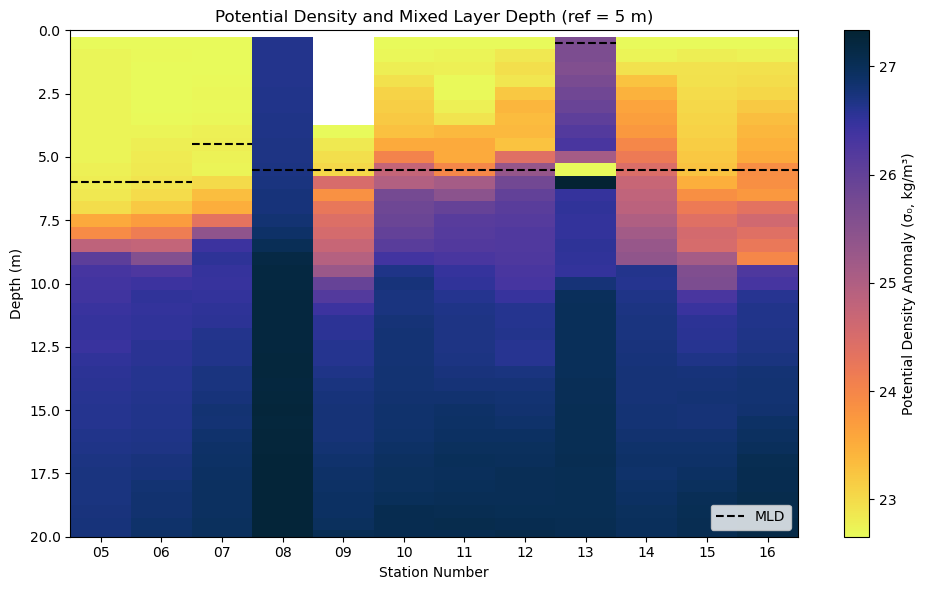

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw
from cmocean import cm as cmo  # <- added import for colormap

# Folder and filenames
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_05_avg.cnv',
    'CTD_06_avg.cnv',
    'CTD_07_avg.cnv',
    'CTD_08_avg.cnv',
    'CTD_09_avg.cnv',
    'CTD_10_avg.cnv',
    'CTD_11_avg.cnv',
    'CTD_12_avg.cnv',
    'CTD_13_avg.cnv',
    'CTD_14_avg.cnv',
    'CTD_15_avg.cnv',
    'CTD_16_avg.cnv'
]

# Set reference depth
ref_depth = 5  # meters

all_depths = []
all_sigma0 = []
mld_list = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute SA and CT
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    # Compute sigma0
    sigma0 = gsw.sigma0(SA, CT)

    # --- Reference density at fixed depth (10 m) ---
    try:
        sigma0_ref = np.interp(ref_depth, depth, sigma0)
    except Exception:
        sigma0_ref = np.nan

    # Mixed layer depth threshold method
    mld = np.nan
    for d, s in zip(depth, sigma0):
        if s - sigma0_ref > 0.03:
            mld = d
            break
    mld_list.append(mld)

    all_depths.append(depth)
    all_sigma0.append(sigma0)

# --- Plot ---
plt.figure(figsize=(10, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    if len(depth) < 2:
        continue  # Skip if too few points for edges

    # Compute edges
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    # Plot sigma0
    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap=cmo.thermal_r,
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    # Plot MLD
    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linewidth=1.5, linestyle='--',
                   label='MLD' if i == 0 else "")

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylim(20,0)
plt.ylabel('Depth (m)')
plt.title(f'Potential Density and Mixed Layer Depth (ref = {ref_depth} m)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_05_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_06_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_07_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_08_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_09_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneD

Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


INFO:pycnv:Converting conductivity units from S/m to mS/cm


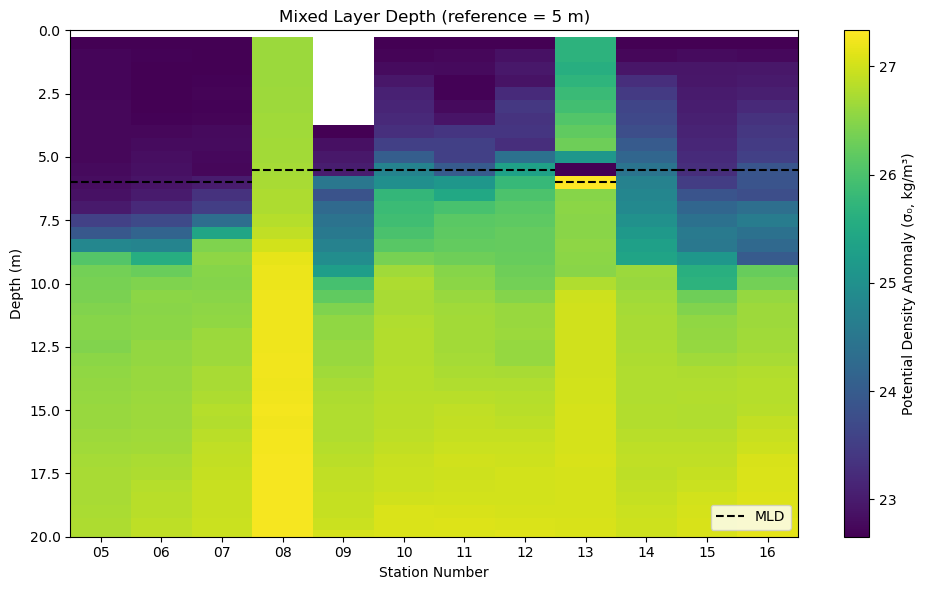

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw

# --- Settings ---
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_05_avg.cnv',
    'CTD_06_avg.cnv',
    'CTD_07_avg.cnv',
    'CTD_08_avg.cnv',
    'CTD_09_avg.cnv',
    'CTD_10_avg.cnv',
    'CTD_11_avg.cnv',
    'CTD_12_avg.cnv',
    'CTD_13_avg.cnv',
    'CTD_14_avg.cnv',
    'CTD_15_avg.cnv',
    'CTD_16_avg.cnv'
]

# --- Initialize ---
all_depths = []
all_sigma0 = []
mld_list = []

# --- MLD Parameters ---
ref_depth = 5  # reference depth in meters
delta_rho_threshold = 0.03  # kg/m³

# --- Loop over files ---
for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute conservative parameters
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)

    # Remove NaNs if any
    valid = ~np.isnan(sigma0) & ~np.isnan(depth)
    depth = depth[valid]
    sigma0 = sigma0[valid]

    # -- MLD calculation using reference depth --
    if len(depth) == 0:
        mld_list.append(np.nan)
        continue

    # Find index closest to reference depth
    ref_idx = np.argmin(np.abs(depth - ref_depth))
    rho_ref = sigma0[ref_idx]

    # Find first depth where Δσ₀ > threshold
    delta_sigma = sigma0 - rho_ref
    above_thresh = np.where(delta_sigma > delta_rho_threshold)[0]

    if len(above_thresh) > 0:
        # Pick the first depth *below the reference* that exceeds threshold
        deeper_than_ref = above_thresh[depth[above_thresh] > depth[ref_idx]]
        mld = depth[deeper_than_ref[0]] if len(deeper_than_ref) > 0 else np.nan
    else:
        mld = np.nan

    mld_list.append(mld)
    all_depths.append(depth)
    all_sigma0.append(sigma0)

# --- Plot ---
plt.figure(figsize=(10, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    # Depth edges for pcolormesh
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap='viridis',
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linestyle='--', linewidth=1.5,
                   label='MLD' if i == 0 else None)

# Final touches
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.ylim(20,0)
plt.title(f'Mixed Layer Depth (reference = {ref_depth} m)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Along Track for day 3

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_17_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_18_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date


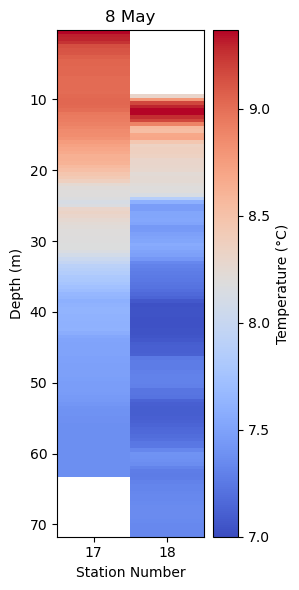

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
from cmocean import cm as cmo

# Load data
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = ['CTD_17_avg.cnv', 'CTD_18_avg.cnv']

all_depths = []
all_temps = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))
    all_depths.append(np.array(cnv.data['depSM']))
    all_temps.append(np.array(cnv.data['t090C']))

# Plot
plt.figure(figsize=(3, 6))

for i, (depth, temp) in enumerate(zip(all_depths, all_temps)):
    # Compute edges for depth
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])

    x_edges = [i - 0.5, i + 0.5]

    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)

    # Expand temp to match (M-1, N-1) = (len(depth), 1)
    T = temp.reshape(-1, 1)

    plt.pcolormesh(X_grid, Y_grid, T, shading='auto', cmap='coolwarm', vmin=7)

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature (°C)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title('8 May')
plt.tight_layout()
plt.show()


In [62]:
for i, depth in enumerate(all_depths):
    print(f"{fnames[i]} max depth: {np.nanmax(depth):.1f} m")


CTD_17_avg.cnv max depth: 63.0 m
CTD_18_avg.cnv max depth: 71.5 m


INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_17_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_18_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date


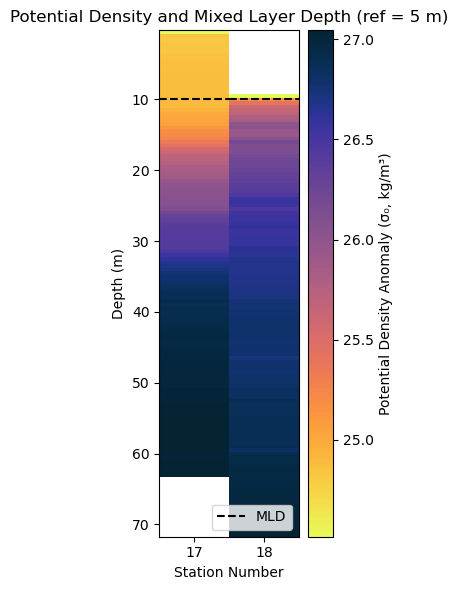

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw
from cmocean import cm as cmo  # <- added import for colormap

# Load data
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = ['CTD_17_avg.cnv', 'CTD_18_avg.cnv']

# Set reference depth
ref_depth = 5  # meters

all_depths = []
all_sigma0 = []
mld_list = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute SA and CT
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    # Compute sigma0
    sigma0 = gsw.sigma0(SA, CT)

    # --- Reference density at fixed depth (10 m) ---
    try:
        sigma0_ref = np.interp(ref_depth, depth, sigma0)
    except Exception:
        sigma0_ref = np.nan

    # Mixed layer depth threshold method
    mld = np.nan
    for d, s in zip(depth, sigma0):
        if s - sigma0_ref > 0.03:
            mld = d
            break
    mld_list.append(mld)

    all_depths.append(depth)
    all_sigma0.append(sigma0)

# --- Plot ---
plt.figure(figsize=(3, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    if len(depth) < 2:
        continue  # Skip if too few points for edges

    # Compute edges
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    # Plot sigma0
    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap=cmo.thermal_r,
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    # Plot MLD
    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linewidth=1.5, linestyle='--',
                   label='MLD' if i == 0 else "")

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title(f'Potential Density and Mixed Layer Depth (ref = {ref_depth} m)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
